* 'ID':
CustID

* 'FirstPolYear':
First Policy Year of the customer’s first policy
May be considered as the first year as a customer

* 'BirthYear':
Birthday Customer’s Birthday Year
The current year of the database is 2016

* 'EducDeg':
Education Academic Degree

* 'MonthSal':
Salary Gross monthly salary (€)

* 'GeoLivArea':
Area Living area 
No further information provided about the meaning of the area codes

* 'Children':
Children Binary variable (Y=1)

* 'CustMonVal':
CMV Customer Monetary Value
Lifetime value = (annual profit from the customer) X (number of years that they are a customer) - (acquisition cost)

* 'ClaimsRate':
Claims Claims Rate
Amount paid by the insurance company (€)/ Premiums (€) Note: in the last 2 years

* 'PremMotor':
Motor Premiums (€) in LOB: Motor
(6)

* 'PremHousehold':
Household Premiums (€) in LOB: Household 
(6)

* 'PremHealth':
Health Premiums (€) in LOB: Health
(6)
 
* 'PremLife':
Life Premiums (€) in LOB: Life
(6)

* 'PremWork':
Work Compensation Premiums (€) in LOB: Work Compensations

(6) Annual Premiums (2016). Negative premiums may manifest reversals occurred in the current year, paid in previous one(s).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 42

In [2]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df['CustID'] = df['CustID'].astype('int')
df = df.set_index('CustID')
#df[df.duplicated(keep=False)].sort_values('FirstPolYear')
df = df[~df.duplicated(keep='first')]

## Encondig Categorical Columns (To corr)

In [3]:
def educDegtransform(row):
    row = row.decode("utf-8") if type(row) == bytes else row 
    if type(row) == str:
        educ_dict = {
            '1 - Basic': 1,
            '2 - High School': 2,
            '3 - BSc/MSc': 3,
            '4 - PhD': 4
        }
        return educ_dict[row]
    else:
        return row

df['EducDeg'] = df['EducDeg'].apply(lambda row: educDegtransform(row)) 

## NaN Treatment

In [4]:
def print_metrics(data, column, name):
    print(f"{name} Mode: {data[column].mode()[0]}")
    print(f"{name} Median: {data[column].median()}")
    print(f"{name} Mean: {data[column].mean():.2f}")
    print(f"{name} Std: {data[column].std():.2f}")
    return

def remove_nan_median(data, column):
    data_2 = data.copy()
    print("NaN After", data[column].isna().sum())
    print_metrics(data_2, column, 'After')
    
    data_2[column] = data_2[column].fillna(data[column].median())
    data_2[column] = data_2[column].astype(int)
    print("\n")
    print("NaN After", data_2[column].isna().sum())
    print_metrics(data_2, column, 'After')

    return data_2

In [5]:
# df_null_values = df.isnull().sum()
# (df_null_values / df.count().max())*100
print(f"Drop NaN {((df.shape[0] - df.dropna().shape[0])/df.shape[0])*100:.2f}%")

Drop NaN 3.00%


In [6]:
df.isnull().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [7]:
#df = df.dropna()

In [8]:
df.isnull().any().any()

True

## Correlation

<AxesSubplot:>

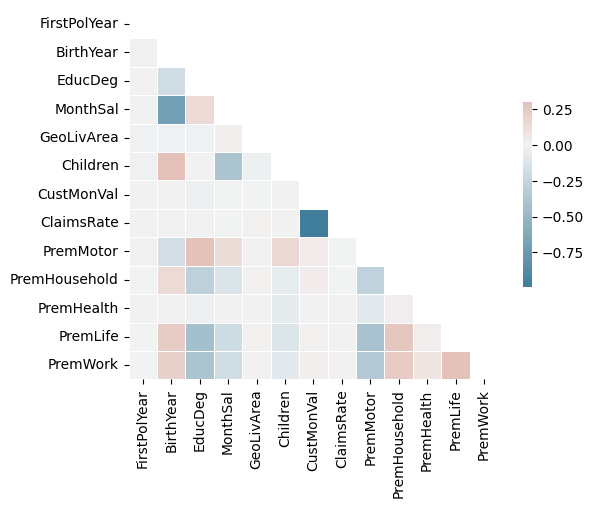

In [9]:
#https://seaborn.pydata.org/examples/many_pairwise_correlations.html
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Columns Check

In [10]:
# KNNImputer - only works for numerical varaibles
# imputer = KNNImputer(n_neighbors=5, weights="uniform")
# df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

### --------------------------------------> FirstPolYear <--------------------------------------

In [11]:
df = df[df['FirstPolYear'] != 53784] #Removes the outlier value 

In [12]:
df['FirstPolYear'].describe(include="all")

count    10262.000000
mean      1986.017833
std          6.612470
min       1974.000000
25%       1980.000000
50%       1986.000000
75%       1992.000000
max       1998.000000
Name: FirstPolYear, dtype: float64

<AxesSubplot:>

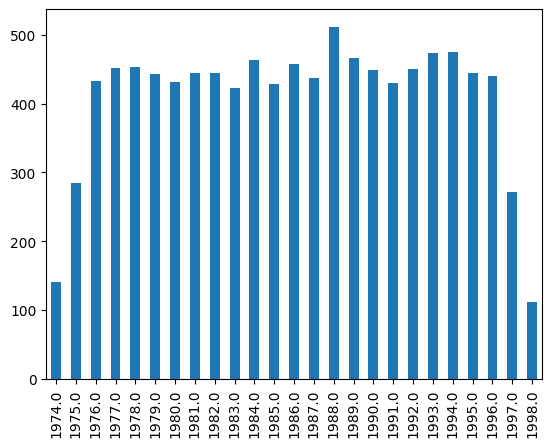

In [13]:
df['FirstPolYear'].value_counts().sort_index().plot(kind='bar')

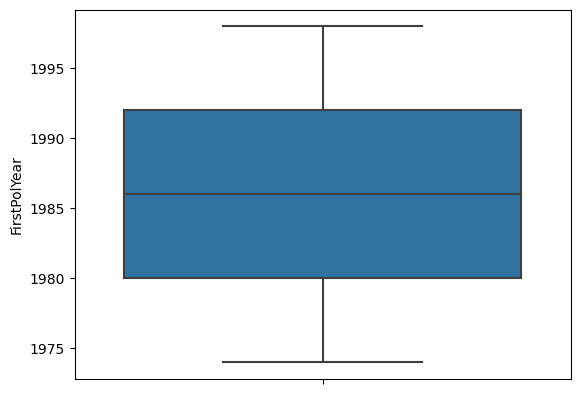

In [14]:
sns.boxplot(y=df["FirstPolYear"])
plt.show()

In [15]:
# moda serie interessante olhando as figuras
# df['FirstPolYear'].fillna(df['FirstPolYear'].mode()[0]).isna().any()
df = remove_nan_median(df, 'FirstPolYear')

NaN After 30
After Mode: 1988.0
After Median: 1986.0
After Mean: 1986.02
After Std: 6.61


NaN After 0
After Mode: 1988
After Median: 1986.0
After Mean: 1986.02
After Std: 6.60


<AxesSubplot:>

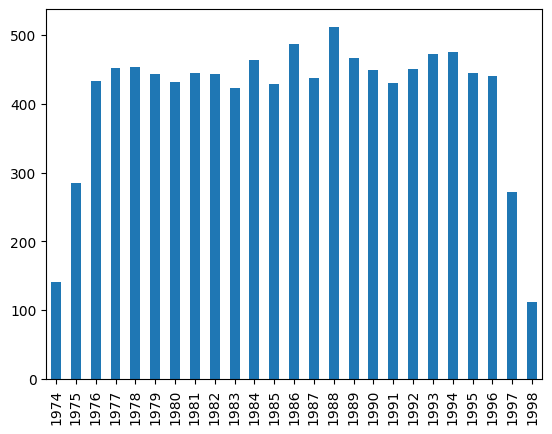

In [16]:
df['FirstPolYear'].value_counts().sort_index().plot(kind='bar')

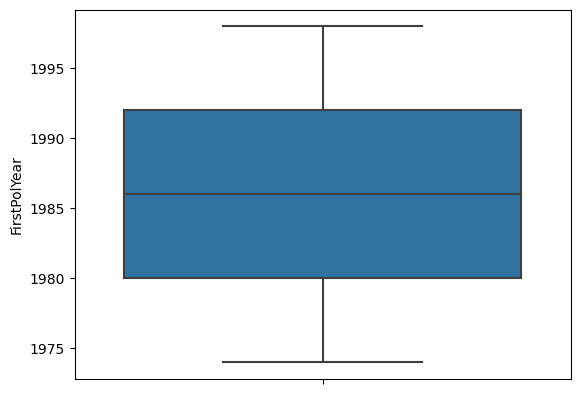

In [17]:
sns.boxplot(y=df["FirstPolYear"])
plt.show()

### --------------------------------------> BirthYear <--------------------------------------

In [18]:
df = df[df['BirthYear'] != 1028]

In [19]:
df['BirthYear'].describe(include="all")

count    10274.000000
mean      1968.100350
std         17.393336
min       1935.000000
25%       1953.000000
50%       1968.000000
75%       1983.000000
max       2001.000000
Name: BirthYear, dtype: float64

<AxesSubplot:>

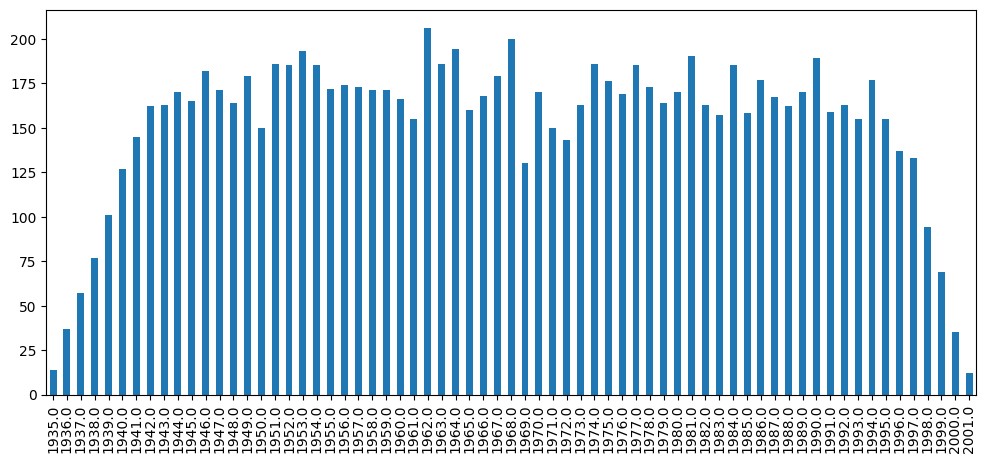

In [20]:
df['BirthYear'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

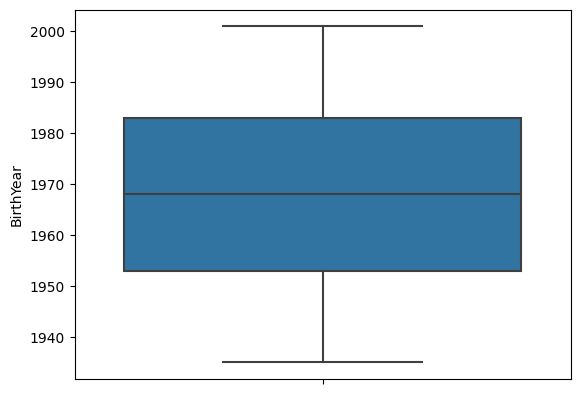

In [21]:
sns.boxplot(y=df["BirthYear"])
plt.show()

In [22]:
df = remove_nan_median(df, 'BirthYear')

NaN After 17
After Mode: 1962.0
After Median: 1968.0
After Mean: 1968.10
After Std: 17.39


NaN After 0
After Mode: 1968
After Median: 1968.0
After Mean: 1968.10
After Std: 17.38


<AxesSubplot:>

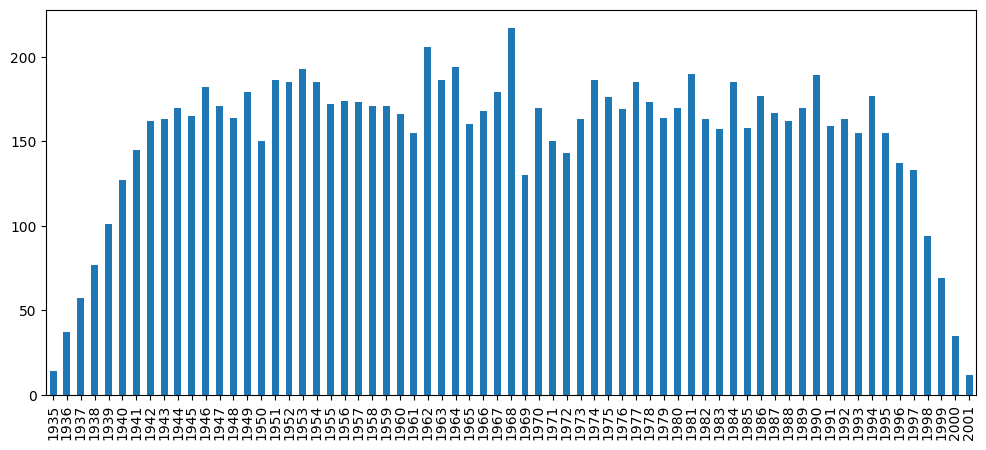

In [23]:
df['BirthYear'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

In [24]:
# Não tem ninguém com a idade menor que 15 anos
df[(2016 - df['BirthYear']) < 15].shape[0]

0

<AxesSubplot:>

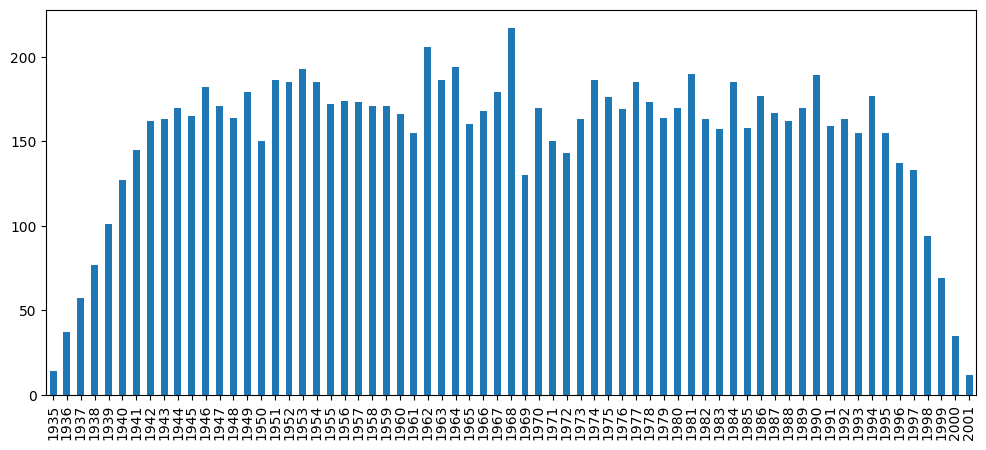

In [25]:
df['BirthYear'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

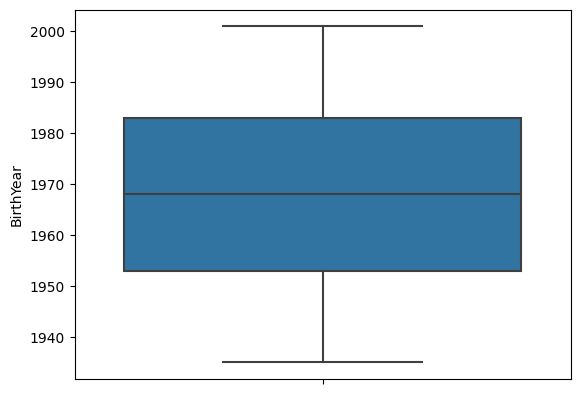

In [26]:
sns.boxplot(y=df["BirthYear"])
plt.show()

### -> Problem between FirstPolYear and BirthYear

In [27]:
print(f"Drop Years {(((df[(df['FirstPolYear'] - df['BirthYear']) < 0].shape[0])/df.shape[0])*100):.2f}%")

Drop Years 19.43%


<AxesSubplot:>

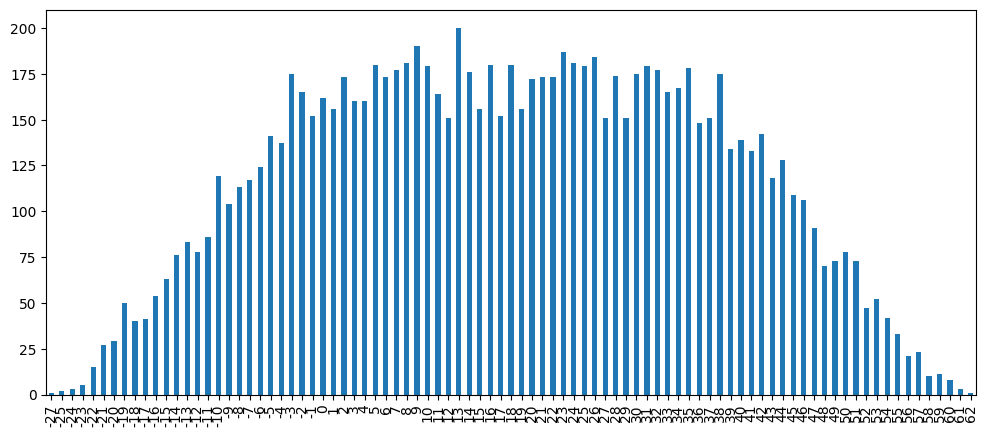

In [28]:
df_2 = df.copy()
df_2['reduce'] = (df_2['FirstPolYear'] - df_2['BirthYear'])
df_2[['FirstPolYear', 'BirthYear', 'reduce']][df_2['reduce']<0]
df_2['reduce'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

### --------------------------------------> EducDeg <--------------------------------------

<AxesSubplot:>

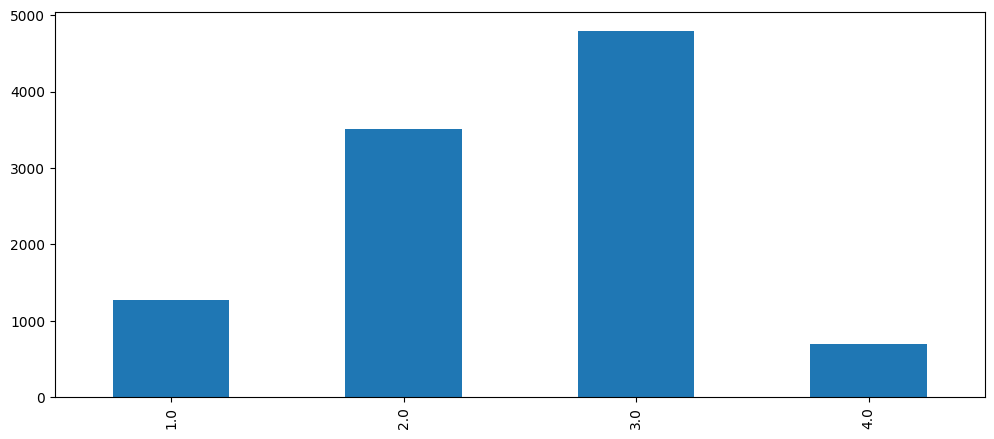

In [29]:
df['EducDeg'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

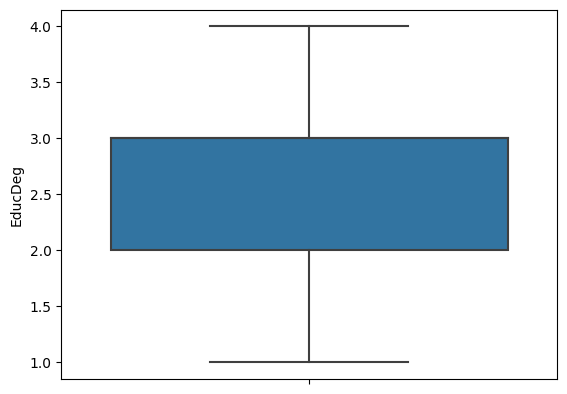

In [30]:
sns.boxplot(y=df["EducDeg"])
plt.show()

In [31]:
df = remove_nan_median(df, 'EducDeg')

NaN After 17
After Mode: 3.0
After Median: 3.0
After Mean: 2.48
After Std: 0.80


NaN After 0
After Mode: 3
After Median: 3.0
After Mean: 2.48
After Std: 0.80


<AxesSubplot:>

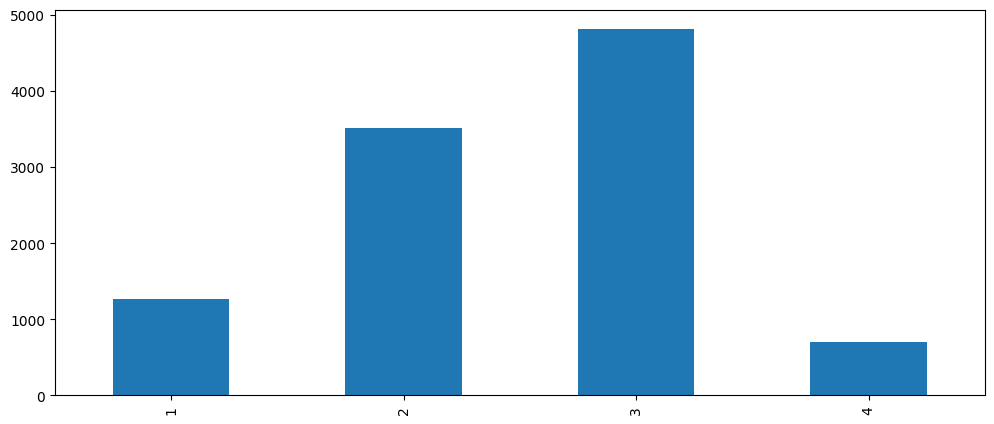

In [32]:
df['EducDeg'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))

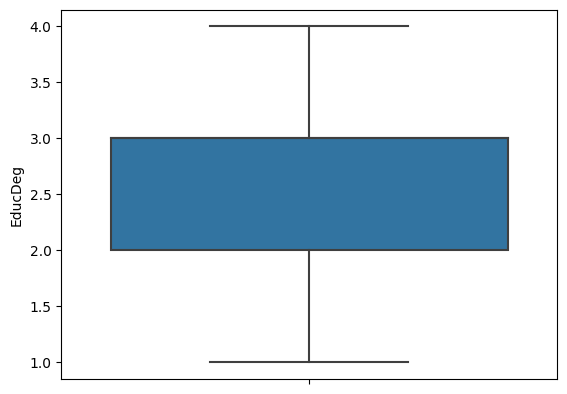

In [33]:
sns.boxplot(y=df["EducDeg"])
plt.show()

### --------------------------------------> MonthSal <--------------------------------------

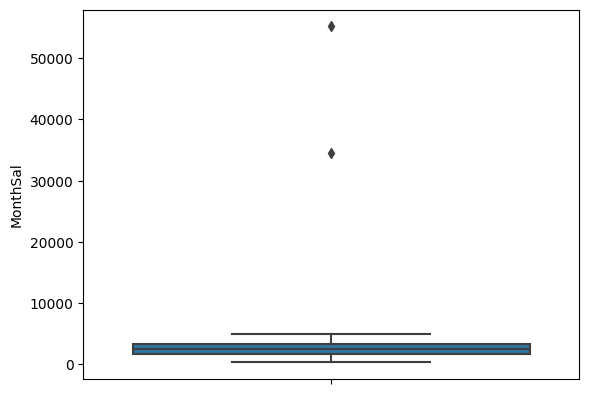

In [34]:
sns.boxplot(y=df['MonthSal'])
plt.show()

In [35]:
# Removendo dois pontos fora da curva
df[df['MonthSal'] > 10000]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
5883,1995,1956,2,55215.0,4.0,1.0,122.25,0.79,281.83,147.25,130.58,84.46,66.68
8262,1981,1991,2,34490.0,4.0,0.0,608.89,0.28,57.01,358.95,195.26,113.80,161.14


In [36]:
print_metrics(df, 'MonthSal', 'MonthSal Before')

MonthSal Before Mode: 1398.0
MonthSal Before Median: 2501.0
MonthSal Before Mean: 2506.51
MonthSal Before Std: 1157.60


In [37]:
df = df[df['MonthSal'] < 10000]

In [38]:
print_metrics(df, 'MonthSal', 'MonthSal After')

MonthSal After Mode: 1398.0
MonthSal After Median: 2501.0
MonthSal After Mean: 2498.25
MonthSal After Std: 984.62


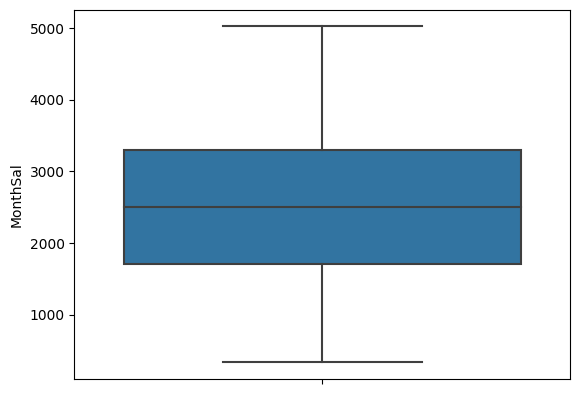

In [39]:
sns.boxplot(y=df['MonthSal'])
plt.show()

In [40]:
df['MonthSal'].describe()

count    10253.000000
mean      2498.252707
std        984.615244
min        333.000000
25%       1706.000000
50%       2501.000000
75%       3290.000000
max       5021.000000
Name: MonthSal, dtype: float64

<AxesSubplot:>

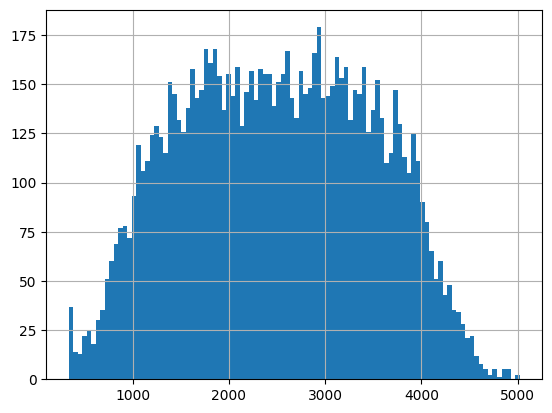

In [41]:
df['MonthSal'].hist(bins = 100)

In [42]:
df = remove_nan_median(df, 'MonthSal')

NaN After 0
After Mode: 1398.0
After Median: 2501.0
After Mean: 2498.25
After Std: 984.62


NaN After 0
After Mode: 1398
After Median: 2501.0
After Mean: 2498.25
After Std: 984.62


### GeoLivArea

In [52]:
df['GeoLivArea'].describe()

count    10252.000000
mean         2.709130
std          1.266415
min          1.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: GeoLivArea, dtype: float64

In [51]:
print_metrics(df, 'GeoLivArea', 'After')

After Mode: 4.0
After Median: 3.0
After Mean: 2.71
After Std: 1.27


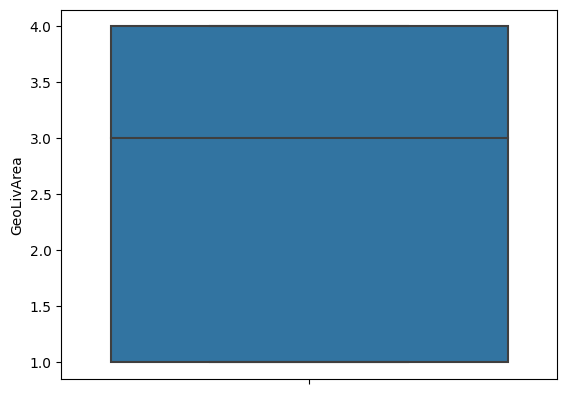

In [43]:
sns.boxplot(y=df['GeoLivArea'])
plt.show()

<AxesSubplot:>

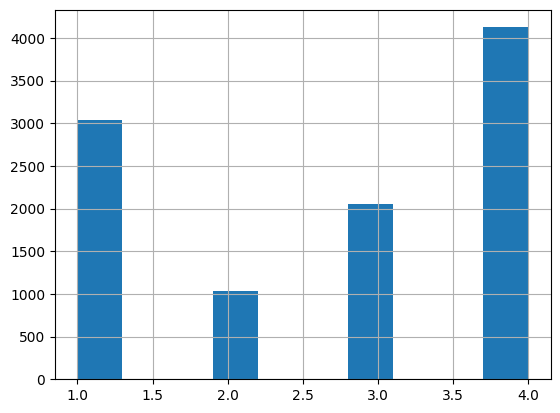

In [48]:
df['GeoLivArea'].hist()

### Children

In [53]:
print_metrics(df, 'Children', 'After')

After Mode: 1.0
After Median: 1.0
After Mean: 0.71
After Std: 0.46


In [54]:
df['Children'].describe()

count    10232.000000
mean         0.706704
std          0.455295
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Children, dtype: float64

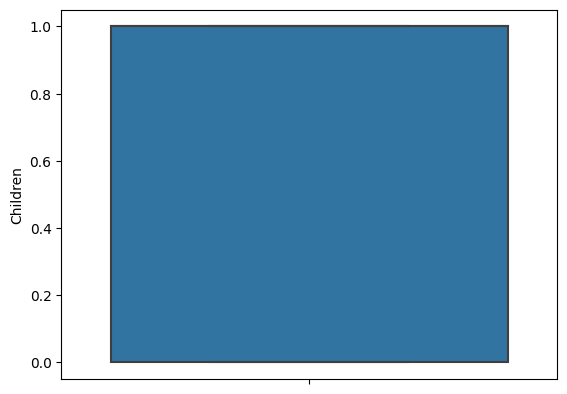

In [44]:
sns.boxplot(y=df['Children'])
plt.show()

<AxesSubplot:>

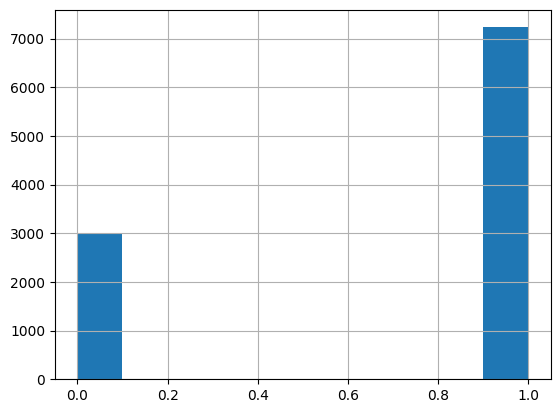

In [49]:
df['Children'].hist()

### CustMonVal

In [55]:
print_metrics(df, 'CustMonVal', 'Before')

Before Mode: -25.0
Before Median: 187.25
Before Mean: 178.03
Before Std: 1949.84


In [56]:
df['CustMonVal'].describe()

count     10253.000000
mean        178.033240
std        1949.842752
min     -165680.420000
25%          -9.440000
50%         187.250000
75%         399.860000
max       11875.890000
Name: CustMonVal, dtype: float64

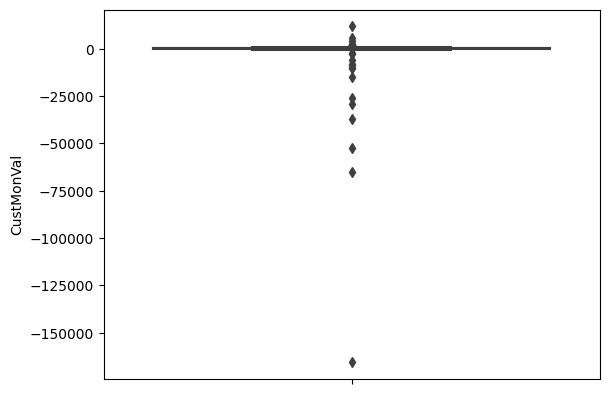

In [57]:
sns.boxplot(y=df['CustMonVal'])
plt.show()

<AxesSubplot:>

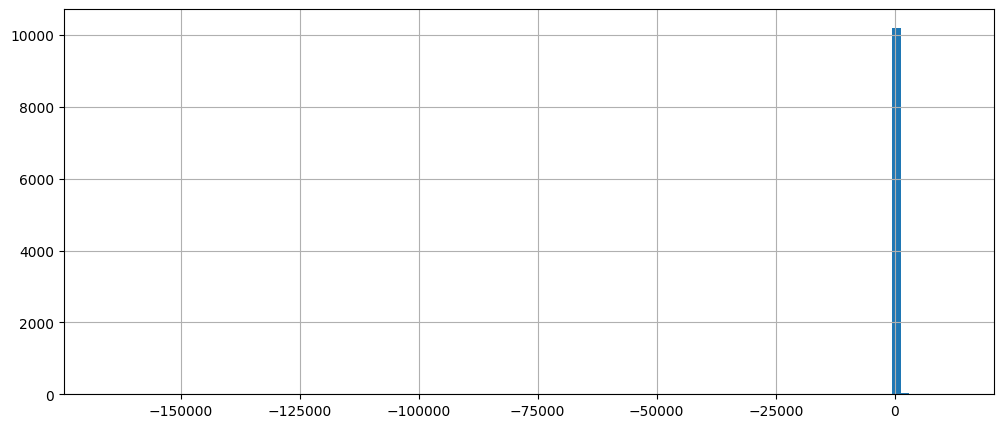

In [65]:
# df['CustMonVal'].hist(bins=1)
# df['CustMonVal'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
df['CustMonVal'].hist(bins=100, figsize=(12,5))